In [22]:
# Assumes you already have a DataFrame `df` in memory like the one you showed:
# columns: ['cik','gvkey','date','mgmt_embedding','ni_be']

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score


In [30]:
df = pd.read_parquet("../../data/training_data_surprise_model/2005_mgmt_training_10Q.parquet", engine='fastparquet')

# Quick sanity check
display(df.head())
print(df.shape)

,cik,gvkey,date,mgmt_embedding,ni_be
0,72911,7980.0,2005-02,"[-0.50434804, 1.337575, -0.1841943, 0.05173105...",-0.034289
1,72911,7980.0,2005-02,"[-0.50434804, 1.337575, -0.1841943, 0.05173105...",-0.034289
2,72911,7980.0,2005-02,"[-0.50434804, 1.337575, -0.1841943, 0.05173105...",-0.034289
3,72911,7980.0,2005-02,"[-0.50434804, 1.337575, -0.1841943, 0.05173105...",-0.034289
4,108312,11580.0,2005-02,"[-0.19345373, 0.9730646, -0.6990452, -0.323367...",0.081330


(11028, 5)


In [31]:
# Assumes you already have a DataFrame `df` in memory like the one you showed:
# columns: ['cik','gvkey','date','mgmt_embedding','ni_be']

import numpy as np
import pandas as pd

from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# Quick sanity check
display(df.head())
print(df.shape)


,cik,gvkey,date,mgmt_embedding,ni_be
0,72911,7980.0,2005-02,"[-0.50434804, 1.337575, -0.1841943, 0.05173105...",-0.034289
1,72911,7980.0,2005-02,"[-0.50434804, 1.337575, -0.1841943, 0.05173105...",-0.034289
2,72911,7980.0,2005-02,"[-0.50434804, 1.337575, -0.1841943, 0.05173105...",-0.034289
3,72911,7980.0,2005-02,"[-0.50434804, 1.337575, -0.1841943, 0.05173105...",-0.034289
4,108312,11580.0,2005-02,"[-0.19345373, 0.9730646, -0.6990452, -0.323367...",0.081330


(11028, 5)


In [32]:
# Convert the list-like embeddings into a 2D array
X = np.vstack(df["mgmt_embedding"].to_numpy())        # shape: (n_samples, 768)
y = df["ni_be"].astype(float).to_numpy()              # shape: (n_samples,)

# Group by issuer to avoid leakage across months of the same firm
groups = df["cik"].astype("Int64").fillna(-1).astype(int).to_numpy()

print("X shape:", X.shape, "y shape:", y.shape, "unique issuers:", np.unique(groups).size)


X shape: (11028, 768) y shape: (11028,) unique issuers: 3751


In [33]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (8843, 768) Test: (2185, 768)


In [34]:
# RidgeCV will choose alpha on the TRAIN set (5-fold by default)
alpha_grid = np.logspace(-3, 3, 13)

ridgecv_pipe = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    RidgeCV(alphas=alpha_grid, cv=5, store_cv_results=False)
)

ridgecv_pipe.fit(X_train, y_train)

best_alpha = ridgecv_pipe.named_steps["ridgecv"].alpha_
print("Best alpha (RidgeCV):", best_alpha)

# Evaluate on test set
y_pred = ridgecv_pipe.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
evs  = explained_variance_score(y_test, y_pred)

# Baseline: predict the train-mean
y_base = np.full_like(y_test, y_train.mean())
mse_b  = mean_squared_error(y_test, y_base)
rmse_b = np.sqrt(mse_b)
r2_b   = r2_score(y_test, y_base)

print(f"Test metrics:")
print(f"  RMSE: {rmse:.4f} (baseline {rmse_b:.4f})")
print(f"  MAE : {mae:.4f}")
print(f"  R^2 : {r2:.4f} (baseline {r2_b:.4f})")
print(f"  EVS : {evs:.4f}")


/Users/tsemerdz/Projects/FIAM2025/.venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.83225e-10): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/tsemerdz/Projects/FIAM2025/.venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.55557e-10): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/tsemerdz/Projects/FIAM2025/.venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.22024e-11): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/tsemerdz/Projects/FIAM2025/.venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.36807e-10): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/tsemerdz/Projects/FIAM2025/.venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAl

Best alpha (RidgeCV): 1000.0
Test metrics:
  RMSE: 9.9271 (baseline 1.9754)
  MAE : 7.6274
  R^2 : -27.8007 (baseline -0.1404)
  EVS : -27.7962


Grouped 5-fold CV R^2: mean = -21.8258 std = 18.4544 folds = [-3.78040e+01 -7.00000e-04 -4.68263e+01 -2.12691e+01 -3.22870e+00]


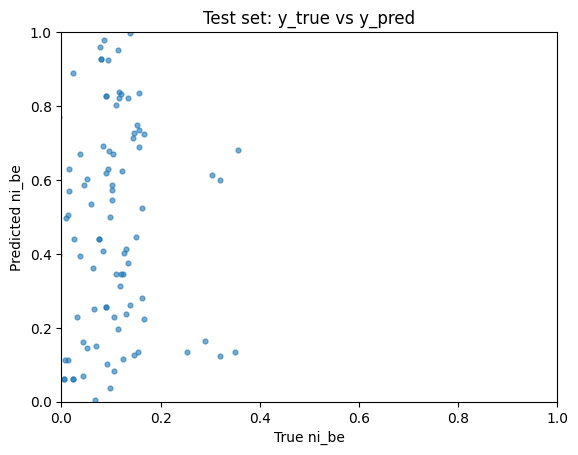

,feature_dim,coef
0,714,-2.715889
1,328,-2.663148
2,10,-2.521836
3,361,-2.352697
4,496,2.339575
5,168,-2.293948
6,628,2.245010
7,119,-2.145851
8,455,-2.032293
9,242,2.012865


In [40]:
# Use GroupKFold so all rows of a CIK stay in the same fold
gkf = GroupKFold(n_splits=5)

# Use the alpha we just found to avoid nested-CV inside CV
best_ridge_pipe = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    Ridge(alpha=best_alpha)
)

cv_scores = cross_val_score(
    best_ridge_pipe, X, y,
    cv=gkf.split(X, y, groups=groups),
    scoring="r2"
)

print("Grouped 5-fold CV R^2: mean =", cv_scores.mean().round(4),
      "std =", cv_scores.std().round(4),
      "folds =", np.round(cv_scores, 4))


# Fit on full data (with chosen alpha) for diagnostics
best_ridge_pipe.fit(X_train, y_train)
y_pred_test = best_ridge_pipe.predict(X_test)

plt.figure()
plt.scatter(y_test, y_pred_test, s=12, alpha=0.6)
plt.xlabel("True ni_be")
plt.ylabel("Predicted ni_be")
plt.title("Test set: y_true vs y_pred")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

# Top coefficients by magnitude
ridge = best_ridge_pipe.named_steps["ridge"]
coefs = ridge.coef_.ravel()
top_idx = np.argsort(np.abs(coefs))[-30:][::-1]  # top-10 by |coef|
pd.DataFrame({
    "feature_dim": top_idx,
    "coef": coefs[top_idx]
})


# Random Forest Model

In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:


# Load data
df = pd.read_parquet("../../data/training_data_surprise_model/2005_mgmt_training_10Q.parquet", engine="fastparquet")

# Convert embeddings column (list-like) into numpy arrays
X = np.vstack(df["mgmt_embedding"].values)
y = df["ni_be"].values

print("Feature matrix:", X.shape)
print("Target vector:", y.shape)


Feature matrix: (11028, 768)
Target vector: (11028,)


In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=50,
    random_state=42,
    n_jobs=-1,
    verbose=1
)


In [79]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.0min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.0s finished


In [80]:


# Train set predictions
y_train_pred = rf.predict(X_train)
train_rmse = root_mean_squared_error(y_train, y_train_pred)

# Test set predictions (already computed as y_pred)
test_rmse = root_mean_squared_error(y_test, y_pred)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test  RMSE: {test_rmse:.4f}")


Train RMSE: 11.5393
Test  RMSE: 39.9450


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.1s finished


In [81]:
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R^2 : {r2:.4f}")
print(f"EVS : {evs:.4f}")


RMSE: 39.9450
MAE : 1.7292
R^2 : 0.6103
EVS : 0.6103


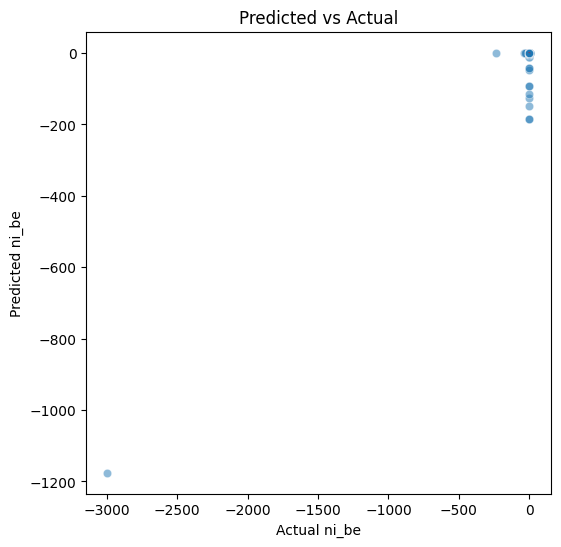

In [82]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual ni_be")
plt.ylabel("Predicted ni_be")
plt.title("Predicted vs Actual")
plt.show()


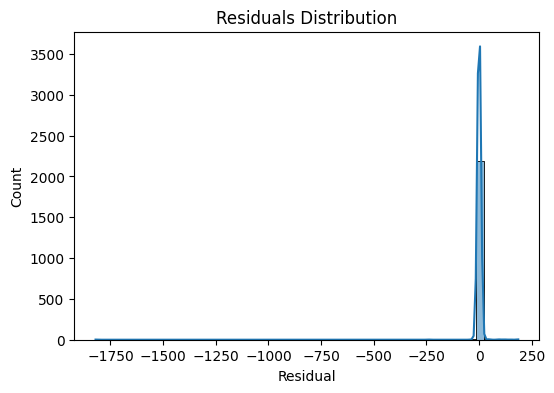

In [83]:
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.show()


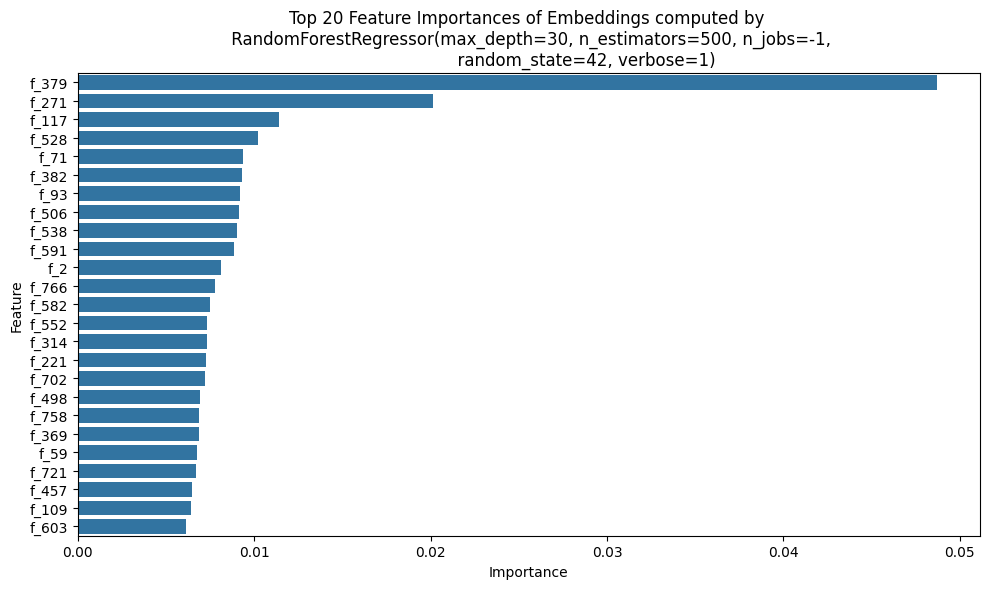

In [84]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:25]

plt.figure(figsize=(10,6))
sns.barplot(
    x=importances[indices], 
    y=[f"f_{i}" for i in indices], 
    orient="h"
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title(f"Top 20 Feature Importances of Embeddings computed by \n {str(rf)}")
plt.tight_layout()
plt.show()


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   

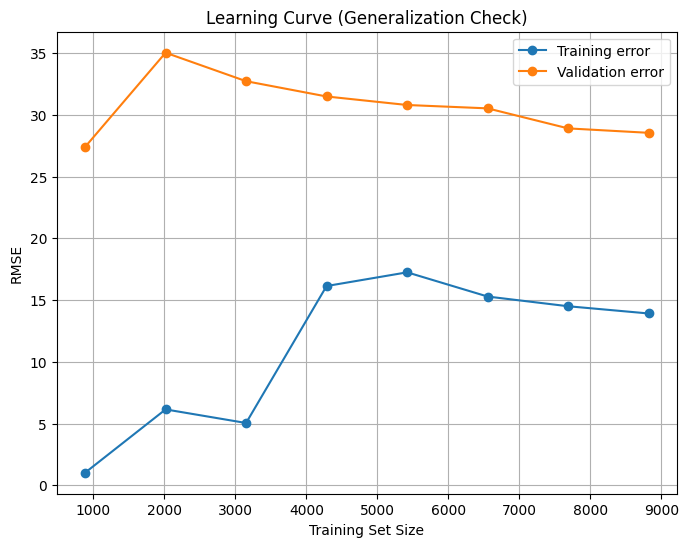

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf, X, y, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8), random_state=42
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)


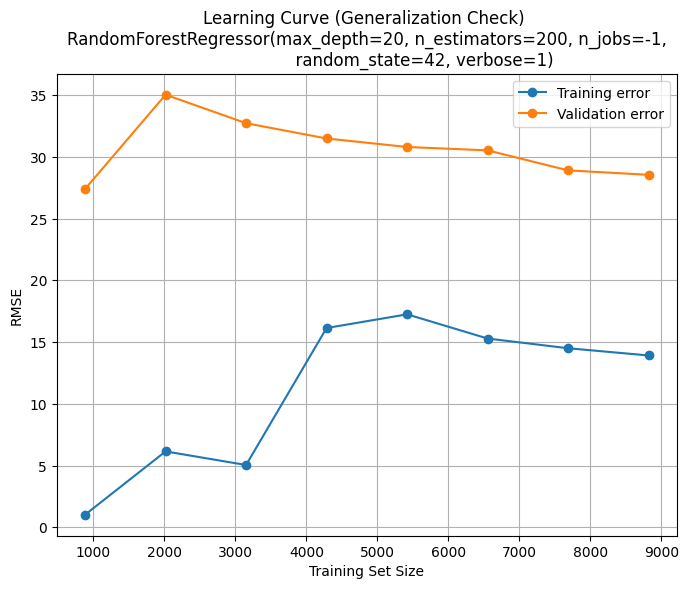

In [73]:
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', label="Training error")
plt.plot(train_sizes, test_mean, 'o-', label="Validation error")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.title(f"Learning Curve (Generalization Check) \n{rf}")
plt.legend()
plt.grid(True)
plt.show()
